# Exercise Sheet 4 - Transfer Learning for Saliency Prediction

* Deep Learning for Computer Vision – Winter Term 2022/23
* Organizers: Anwai Archit, Laura Hansel, Michaela Vystrčilová, Constantin Pape
* Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
* Due date: **Monday, Dec 19, before 14:00**

In this assignment you will learn how to use transfer learning to predict where people will look in images. We will work with the MIT 1003 dataset which consists of 1003 images together with fixation data from human subjects. Transfer learning allows us to reuse the features from a model that has been pretrained on a larger dataset. Here we will use VGG19 pretrained on ImageNet.

The goals of this assignment are as follows:

*   Extract features from a model pretrained on ImageNet.
*   Implement a simple readout network and train it on the data.
*   Define a loss function and a seperate evaluation metric.
*   Visualize the best and the worst results.

## Hints

To understand the idea of the exercise sheet, inspired by a paper called DeepGaze we suggest the following.

* Review the lecture
* It will be very helpful to read the according paper [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 

Although the general idea of the exercise will be the same as in the paper, we changed some details: 
   * we will use VGG instead of caffe net
   * we will not do the same thorough analysis and
   * other details are changed as well to make this exercise simpler.

*Do not hesitate to ask questions and ideally discuss them with your fellow students and tutors on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck. Also, we are happy to help in our office hours - looking forward seeing you there!*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of homework 3`.
- make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.

### 1. Import required libraries


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from skimage import io, transform
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 2. Get the data

The MIT 1003 dataset is publicly available at https://people.csail.mit.edu/tjudd/WherePeopleLook/index.html

For your convenience there is a shared folder on Google Drive: https://drive.google.com/drive/folders/1GoYw3jp9kWLmHN7qylDS5QTo_ebnaMDD?usp=sharing
You can click the link and add the folder to your Drive (it does not count into your disk quota).

If you're using Kaggle (recommended) or Colab, you can uncomment the corresponding code in the following cell. With Kaggle you can download the data to your Kaggle environment. With Colab you can to mount your Google drive. 

In [2]:
# Steps for Connecting with Google Colab
"""
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
# sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Deep Learning')
"""

# Steps for Connecting with Kaggle
"""
Run the scripts as it is by uncommenting the snippets below and it should be fine
"""
!conda install -y gdown
# File Location - https://drive.google.com/drive/folders/1NIWYdrGCSFR86mmCBYFDgXs86TMZ9GKo?usp=sharing (we only need the id)
!gdown --id 1NIWYdrGCSFR86mmCBYFDgXs86TMZ9GKo --folder

# unzip the mounted 
! unzip "/kaggle/working/DL/ALLSTIMULI.zip" -d "MIT_1003"
! unzip "/kaggle/working/DL/ALLFIXATIONMAPS.zip" -d "MIT_1003"

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    filelock-3.8.2             |     pyhd8ed1ab_0          14 KB  conda-forge
    gdown-4.6.0                |     pyhd8ed1ab_0          18 KB  conda-forge
    openssl-1.1.1s             |       h0b41bf4_1         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages

In [3]:
main_path = "/kaggle/working/"
data_path = os.path.join(main_path, "MIT_1003")

### 3. Prepare the data

In [4]:
images_files_all = sorted([
    os.path.join(data_path, "ALLSTIMULI", f)
    for f in os.scandir(os.path.join(data_path, "ALLSTIMULI"))
    if f.path.endswith(".jpeg")
])
print("Total Number of Images: {} (should be 1003)".format(len(images_files_all)))

Total Number of Images: 1003 (should be 1003)


In [5]:
# fix the seed for reproducible splitting
np.random.seed(1234)
train_idx = np.random.choice(len(images_files_all), len(images_files_all) // 2, replace=False)
test_idx = np.setdiff1d(np.arange(len(images_files_all)), train_idx)

images_files = {}
images_files["train"] = [images_files_all[i] for i in train_idx]
images_files["test"] = [images_files_all[i] for i in test_idx]
print("Number of Train Images: {}".format(len(images_files["train"])))
print("Number of Test Images: {}".format(len(images_files["test"])))

fixation_maps_binary_files = {}
fixation_maps_binary_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["train"]
]
fixation_maps_binary_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixPts.jpg")
    for filename in images_files["test"]
]
fixation_maps_blurred_files = {}
fixation_maps_blurred_files["train"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["train"]
]
fixation_maps_blurred_files["test"] = [
    os.path.join(data_path, "ALLFIXATIONMAPS", os.path.splitext(os.path.basename(filename))[0] + "_fixMap.jpg")
    for filename in images_files["test"]
]

Number of Train Images: 501
Number of Test Images: 502


### 4. Show an example from the dataset

In [7]:
image = io.imread(images_files["train"][0])
binary_map = io.imread(fixation_maps_binary_files["train"][0])
blurred_map = io.imread(fixation_maps_blurred_files["train"][0])
fixations = np.where(binary_map)

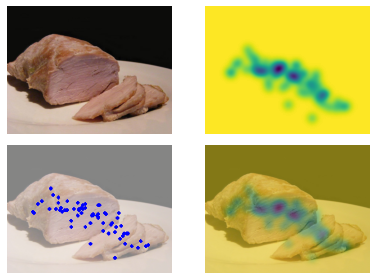

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis("off")
ax1.imshow(image)
ax2.axis("off")
ax2.imshow(blurred_map, cmap="viridis_r")
ax3.axis("off")
ax3.imshow(image, alpha=0.5)
ax3.scatter(fixations[1], fixations[0], s=1, marker=".", c="b")
ax4.axis("off")
ax4.imshow(image)
ax4.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
fig.tight_layout()

### 5. Preprocess images and maps

The images have different sizes and orientations. To simplify our task we downscale the images and crop them to a size of 256x256 pixels. At this size, all of the images should fit into memory at once.

In [9]:
def preprocess_data(images_paths, fixations_binary_paths, fixations_blurred_paths, shape):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(shape),
            torchvision.transforms.CenterCrop(shape),
        ]
    )

    n = len(images_paths)
    ims = np.empty((n, shape, shape, 3), dtype=np.int)
    fixs_binary = np.empty((n, shape, shape))
    fixs_blurred = np.empty((n, shape, shape))

    for i, path in enumerate(tqdm(images_paths)):
        image = io.imread(path)
        image = transform(image)
        image = np.array(image, dtype=np.int)
        ims[i] = image

    for i, path in enumerate(tqdm(fixations_binary_paths)):
        fixations_binary = io.imread(path, 0)
        fixations_binary = transform(fixations_binary)
        fixations_binary = np.array(fixations_binary)
        fixs_binary[i] = fixations_binary

    for i, path in enumerate(tqdm(fixations_blurred_paths)):
        fixations_blurred = io.imread(path, 0)
        fixations_blurred = transform(fixations_blurred)
        fixations_blurred = np.array(fixations_blurred)
        fixs_blurred[i] = fixations_blurred

    data = {"images": ims, "fixations_binary": fixs_binary, "fixations_blurred": fixs_blurred}
    return data

In [10]:
# If data is already preprocessed and saved, load it, otherwise preprocess and save it.
# If you do not whish to save the data comment the according lines.
# If you want to re-run data preprocessing, you may have to delete the saved file.

train_data_file = os.path.join(main_path, "train_data.npy")

if os.path.isfile(train_data_file):
    train_data = np.load(train_data_file, allow_pickle=True)[()]
else:
    train_data = preprocess_data(
        images_files["train"], fixation_maps_binary_files["train"], fixation_maps_blurred_files["train"], 256
    )
    np.save(train_data_file, train_data)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 0/501 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you 

### 6. Implement a PyTorch dataset for our data

We need the `torch.utils.data.Dataset`  to access the data conveniently. Later, it is required to have access to the data through this class to build a Pytorch dataloader.

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_data, features=None):
        self.features = features
        self.data = preprocessed_data

    def __getitem__(self, key):
        raw_image = self.data["images"][key]

        normalized_image = raw_image.astype(np.float32) / 255.0  # -> [0, 1]
        normalized_image -= np.array([0.485, 0.456, 0.406])  # subtract mean
        normalized_image /= np.array([0.229, 0.224, 0.225])  # divide by SD
        normalized_image = normalized_image.transpose(2, 0, 1)  # HWC -> CHW

        fixations_binary = self.data["fixations_binary"][key]
        fixations_blurred = self.data["fixations_blurred"][key]

        data = {
            "raw_image": raw_image,
            "normalized_image": normalized_image,
            "fixations_binary": fixations_binary,
            "fixations_blurred": fixations_blurred,
        }

        if self.features is not None:
            data["features"] = self.features[key]

        return data

    def __len__(self):
        return len(self.data["images"])

The collate_fn will be used in the dataloader. It converts the batched data into tensors. We use a sparse tensor for the binary fixations because they contain mostly zeros.

In [12]:
def to_sparse(x):
    """converts dense tensor x to sparse format"""
    x_typename = torch.typename(x).split(".")[-1]
    sparse_tensortype = getattr(torch.sparse, x_typename)

    indices = torch.nonzero(x)
    if len(indices.shape) == 0:  # if all elements are zeros
        return sparse_tensortype(*x.shape)
    indices = indices.t()
    values = x[tuple(indices[i] for i in range(indices.shape[0]))]
    return sparse_tensortype(indices, values, x.size())


def collate_fn(batch):
    batch_data = {
        "image": torch.tensor([item["normalized_image"] for item in batch]),
        "fixations_binary": to_sparse(torch.tensor([item["fixations_binary"] for item in batch])),
        "fixations_blurred": torch.tensor([item["fixations_blurred"] for item in batch]),
    }
    if "features" in batch[0].keys():
        batch_data["features"] = torch.tensor([item["features"] for item in batch], dtype=torch.float)
    return batch_data

### 7. Compute (center) bias

People tend to look towards the center of the image. This is both due to a bias in our expectations as well as the tendency of photographers to place the interesting objects in the center of the photo. Thus, in the fixation data there is a bias towards the center of the image. We can calculate this bias and incorporate it into our model explicitly by using a gaussian filter on the images. The filter will always put more emphasis on what is in the center.

**TO DO:** To compute the bias: 
1. Sum all the binary fixation maps - *pixels with the highest values will be the ones where people overall looked most at*
1. Normalize by dividing through the maximum value - *this way we get values between 0 and 1* 
1. Apply a Gaussian filter with standard deviation 10 to smooth the result - *smoothing is a way of regularization*
1. Compute the natural logarithm

*Hints:*
- Use the `ImageDataset` class to directly access the data; no pytorch data loader is required here.
- For Gaussian filtering, you can use `gaussian_filter` from `scipy.ndimage`

**Note:**
If people had a different bias than towards the center, the steps above would also compute it. But we know the bias is towards the center, that is why it's called center bias.

In [13]:
from scipy.ndimage import gaussian_filter

# Instantiate the pytorch dataset. (Note that although it contains the same data,
# as `train_data` above, the objects are different. Here, we could use `train_data`)
# instead of `dataset_train`, however, to build a pytorch dataloader later, we
# have to use the `dataset_train` object.

dataset_train = ImageDataset(train_data)
fixations_binary = dataset_train.data["fixations_binary"]

In [14]:
# TODO
center_bias = torch.zeros((1,256,256))
max_val = 0

for e in fixations_binary:
    center_bias += e
    
    local_max = e.max()
    max_val = local_max if local_max > max_val else max_val

center_bias /= max_val
center_bias = gaussian_filter(center_bias, 10)
center_bias = torch.log(torch.tensor(center_bias))

Plot the result

Text(0.5, 1.0, 'Center bias')

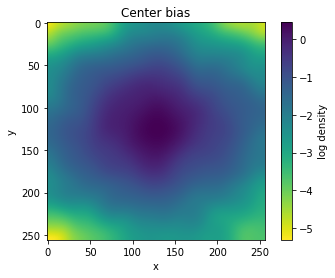

In [15]:
plt.figure()
plt.imshow(center_bias[0], cmap="viridis_r")
cb = plt.colorbar().set_label("log density")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Center bias")

Your plot should look like this:

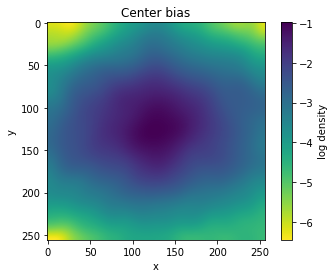

Save/Load center bias

In [16]:
center_bias_file = os.path.join(main_path, "center_bias.npy")

if os.path.isfile(center_bias_file):
    center_bias = np.load(center_bias_file)
else:
    np.save(center_bias_file, center_bias)

### 8. Extract feature maps

Load the VGG19 model pretrained on ImageNet. Use it to process the images in the train dataset: For each image, extract its feature map representation from the Conv2d layer `vgg19.features[30]`. For that, you have to constraint the vgg19 model such that all it's layers up to (including) layer 30 process the image. The subsequent layers of the model are not required to extract the feature maps. You should save them in a Numpy array of shape `(num_input_images, num_channels, x, y)`.

**Theory question and hint**:
- Which shape do you expect for the numpy array? Calculate the values by hand
- You can verify that you calculated correctly with the code you will write for this task

*Hints:*
- Here you will have to define and use a pytorch `DataLoader` object
    - feed in the train set of type `torch.utils.data.Dataset` created above
    - use the `collate_fn` defined above
    - do not shuffle the images (i.e. the data points), so we can save the feature map representations of the images. That way, we can use the feature map representations later and still identify the according image we used to create them.
- cf. https://pytorch.org/docs/stable/torchvision/models.html. If you are wondering if we normalized images, check code in `ImageDataset`
- Define a `feature_extractor` object, containing those parts of the pre-trained VGG19 models that you need to extract the feature map representations from the Conv2d layer `vgg19.features[30]`
    - Don't forget to put your feature extractor in evaluation mode
    - To avoid problems with memory, you can wrap the feature extraction with `torch.no_grad

In [17]:
#TODO
vgg = models.vgg19(pretrained=True)
feature_extractor = vgg.features[:31].to(device)
data_loader = torch.utils.data.DataLoader(dataset_train, collate_fn=collate_fn)

feature_extractor.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [77]:
def compute_train_features():
    arr = np.zeros((501, 512, 16, 16))
    with torch.no_grad():
        for i, x in enumerate(data_loader): # 501 size
            out = feature_extractor(x['image'].to(device))
            arr[i] = out.cpu().detach().numpy()
    
    return arr

### 9. Save the features to a file

Processing the images can take a few minutes. However, you only have to do it once. Thus it is a good idea to save the features to a file that you can load again later.

In [84]:
features_file = os.path.join(main_path, "features_train.npy")

if os.path.isfile(features_file):
    features = np.load(features_file)

else:
    features = compute_train_features()

    # sanity check:
    # in the 1st feature map, is the 10 x 10 matrix defined by the first 10
    # height and width entries computed correctly?
    # fmt: off
    expected_values = np.array(
    [[ -5.05856514,  -5.4494257 ,  -4.04797173,  -4.00965357,
         -3.81041431,  -3.70049334,  -3.4691658 ,  -3.33066201,
         -3.46696138,  -3.73726773],
       [ -6.3092165 ,  -6.64189959,  -4.25930309,  -3.98219156,
         -3.24017859,  -3.00728726,  -2.9968071 ,  -3.60749149,
         -4.02913189,  -4.39249563],
       [ -3.42980075,  -3.04784107,  -2.05232024,  -2.40027595,
         -1.40099525,  -0.51563621,   0.20033906,  -0.37016585,
         -0.84697777,  -1.10821617],
       [ -4.69450617,  -4.35960007,  -2.98953676,  -2.70576119,
         -2.62578845,  -2.11511397,  -0.68794125,  -0.58827341,
         -0.71196592,  -0.81783342],
       [ -4.76338863,  -6.2135601 ,  -5.2962575 ,  -5.73660374,
         -5.61037779,  -4.53765774,  -2.5711813 ,  -1.17775714,
          0.11070768,   0.57022107],
       [ -4.61159277,  -7.80154657,  -7.14027071,  -9.02617931,
         -9.96448612,  -9.96775627,  -7.93922615,  -4.81323099,
         -1.49802375,   0.16369806],
       [ -1.97690308,  -5.60399246,  -5.94019413,  -8.35467911,
         -8.34007072, -10.02152252, -10.62400055,  -8.92269707,
         -4.9632473 ,  -2.63384819],
       [ -2.03594875,  -5.8626318 ,  -5.21619272,  -3.86745071,
         -2.13602161,  -4.00327349,  -7.24868536,  -9.66466331,
         -9.5114603 ,  -8.05636787],
       [ -0.08571954,  -2.13494349,  -2.18564558,  -2.49912596,
         -1.9960444 ,  -2.62563705,  -5.04191208,  -7.47077799,
         -8.94375992,  -9.3424015 ],
       [  2.41950774,   1.38582683,   0.01735479,  -5.72050619,
         -5.90604067,  -4.65355062,  -6.06961155,  -7.60495043,
         -8.39218903,  -8.17572594]]
    )
    # fmt: on
    assert np.allclose(features[0, 0, :10, :10], expected_values, atol = 0.00001), "Feature maps look different than expected"

    np.save(features_file, features)

Add the features to the dataset and define a data loader for training our model. Feel free to change the batch size.

In [85]:
dataset_train = ImageDataset(train_data, features=features)

data_loader_train = torch.utils.data.DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=64,
    collate_fn=collate_fn,
    pin_memory=False,
)

### 10. Define the model

Now we need to define the model we want to train. Two parts are necessary:

1. Readout Network

The readout network gets the feature maps we extracted from VGG19 as input. The network could be of arbitrary complexity but in our case we want to keep it simple: it contains only one layer that takes a linear combination of the features at each location (using 1x1 convolution).

2. Finalizer

The finalizer takes the output of the readout network and scales it up to the size of our images (256x256). It then applies a Gaussian filter to blur the result of the upscaling and adds the center bias. Finally, it performs normalization using a (log) softmax to return the logarithm of the fixation probability densities, later refered to as `log_density`.

*Hints:*
- What are in- and out-shapes of the readout network? What are the parameters you have to pass to the constructor of the 1x1 convolution, then?
- Don't forget to give a learnable weight to the center bias, $\alpha$ in [Kümmerer, Theis, and Bethge (2015)](https://arxiv.org/abs/1411.1045). 
- In `Finalizer` below, initialize `self.gaussian_blur = GaussianBlur2d()` and use `self.gaussian_blur` in `forward(...)`.
- You might want to use `F.interpolate` to scale up the images after the readout network
- The finalizer output is of shape `(batch, x_pixels, y_pixels)`
- Use vectorized and torch functions (not for loops)
- Log softmax: The finalizer should return the logarithm of the fixation probabilities. Here is how to rewrite the math of the paper cited above accordingly:

$$ \ln p(x, y)=\ln \frac{\exp (o(x, y))}{\sum_{x, y} \exp (o(x, y))} = o(x, y)-\ln{\sum_{x, y} \exp (o(x, y))} $$

Where $ p(x,y) $ referst to the probability of a fixation at a certain pixel position $ (x,y) $ and $ o(x,y) $ is the output of the finalizer.
(Note that in the paper $\log$ refers to the natural logarithm $\ln$. The paper also adds a regularization term which we can ignore in this step). We recommend you to use `logsumexp` to compute the softmax in log-space.

In [ ]:
class GaussianBlur2d(nn.Module):
    """
    This class applies a Gaussian filter to a tensor. You should 
    use it *after* upscaling to image size (256x256). The kernel
    size and the standard deviation are fixed and you don't need
    to change them.
    """
    
    def __init__(self):
        super().__init__()

        self.kernel_size = 121
        self.sigma = 20
        self.pad = 60

        grid = torch.arange(float(self.kernel_size)) - self.pad

        kernel_shape = [self.kernel_size]
        grid = nn.Parameter(grid.view(kernel_shape), requires_grad=False)
        kernel = torch.exp(-0.5 * (grid / self.sigma) ** 2)
        kernel = kernel / kernel.sum()
        self.kernel_x = nn.Parameter(kernel[None, None, :, None], requires_grad=False)
        self.kernel_y = nn.Parameter(kernel[None, None, None, :], requires_grad=False)
        
    def forward(self, tensor):
        """Applies the gaussian filter to the given tensor"""
        out = F.conv2d(tensor, self.kernel_x, padding=self.pad)
        out = F.conv2d(out, self.kernel_y)

        return out

In [ ]:
#TODO
readout_network = 

In [ ]:
class Finalizer(nn.Module):
    """Returns logarithm of the fixation probability densities, shape: (batch, x_size, y_size)"""

# TODO


In [ ]:
class Model(nn.Module):
    def __init__(self, readout_network, finalizer):
        super().__init__()
        self.readout_network = readout_network
        self.finalizer = finalizer

    def forward(self, x, centerbias):
        x = self.readout_network(x)
        x = self.finalizer(x, centerbias)
        return x

    def train(self, mode=True):
        self.readout_network.train(mode=mode)
        self.finalizer.train(mode=mode)

In [ ]:
finalizer = Finalizer()
model = Model(readout_network, finalizer)

### 11. Define the metrics

We use two different metrics, one for training and one for evaluating the performance of our model. Remember that we did this for the past exercises, too: back then, we used the cross-entropy loss for training and accuracy for validation.

Here, for the training, we use the **negative log-likelihood (NLL)**. Implement a function that calculates the negative log-likelihood of a fixation mask (which are the labels in our data) under the model prediction `log_density` (i.e. the logarithm of the fixation probability density maps). 

*Hints:* 
The negative log-likelihood we want to use is a slight modification of the equation (last one on page 3) given in Kümmerer, Theis, and Bethge (2015): we ignore the regularization term. Hence, we obtain

$$c(\alpha, w)=-\frac{1}{N} \sum_{i=1}^{N} \ln \hat{p}\left(x_{i}, y_{i}\right) \ .$$

In the NLL we evaluate the model's predictions. Our model predicts the fixation probability $\hat{p}$ at the positions $(x,y)$. We want to compare it to the number of fixations at these positions in our labeled data. Note that the elements in the binary fixation masks $f(x_j, y_k)$ (our labels) count how many fixations ocurred at position $(x_j, y_k)$.

Let's rewrite the NLL in a way you can directly implement into code: We compute the inner product of the model predictions $\hat{p}(x_j, y_k)$ and ground truth binary fixation masks $f(x_j, y_k)$ (they have the same shape) and divide by the fixation count $N$. Additionally, we compute the mean over images $b$ in our batch. This way, we obtain

$$\tilde{c}(\alpha, w) = \frac{1}{b} \sum_b^B \underbrace{ (-1) \frac{1}{N} \sum_{j,k} \ln (\hat{p}(x_{j}, y_{k} |\, \mathrm{image} \ b)) \cdot f(x_{j},y_{k} |\, \mathrm{image} \ b) }_{c(\alpha, w)} \ .$$

**Note:**
- The conditioning on the image is there to express that the probability of fixations we predict is conditioned, i.e. depends on the image for which we are predicting the fixations.

**Questions:**
- Why can we re-write the expression $c(\alpha, w)$ like this? 
- What values can the elements of $f(x_{j},y_{k} |\, \mathrm{image} \ b)$ obtain?
- On the lecture slides the loss contained a *sum* over images. Here, for practical reasons we compute the *mean* over images instead. Why is that advantageous?

Implement $\tilde{c}(\alpha, w)$. You may want to
- Convert the sparse binary `fixation_mask` to a dense one using `t.to_dense()` to be able to compute the inner product of $f$ with the predictions $\hat{p}$.
- Compute the mean across batches

In [ ]:
def neg_log_likelihood(log_predictions, fixation_mask):
    #TODO

For evaluation, we want to use the *normalized scanpath saliency* (NSS; [Peters, Iyer, Itti, and Koch (2005), Section 2.10](https://doi.org/10.1016/j.visres.2005.03.019)). To compute NSS, normalize the model's saliency map which is the model's prediction $\mathrm{SM}(x,y)$ to have zero mean and unit standard deviation,

$$Z_{\mathrm{SM}}(x,y) = \frac{\mathrm{SM}(x,y) - \mu}{\sigma}\ ,$$

where $\mu$ and $\sigma$ are the mean and the standard deviation of the saliency map, respectively. Then, average the according responses at all fixations $(x_i,y_i)$,

$$\mathrm{NSS} = \frac{1}{b} \sum_b^B {(\frac{1}{N} \sum_{j,k} {Z_{SM}}(x_{j}, y_{k} |\, \mathrm{image} \ b) \cdot f(x_{j},y_{k} |\, \mathrm{image} \ b))}\ $$

Implement this as a function.

*Hints:*
- For the evaluation of this metric, the saliency map $\mathrm{SM}(x,y)$ is *not* supposed to be in log-space. Therefore the saliency map should be given an exponential of the `log_predictions`: $\mathrm{e}^{\hat{p}(x, y)}$.
- Remember the hints from above: 
    - Compute the mean across batches

In [ ]:
def nss(log_predictions, fixation_mask):
    #TODO

### 12. Train the model

Now iterate through the dataloader to train the model on the train dataset. You can use the Adam optimizer with default parameters. You should print the NLL and the NSS of the train dataset after each training epoch to monitor the progress. Train for at least 5 epochs. You are welcome to reuse and adapt the code you used on the previous exercise sheets for model training, but you don't have to.

*Hints:*
- Do we want to maximize or minimize the negative log-likelihood?
- In our reference implementation, after the fifth epoch we got `NLL: 10.0   NSS: 3.9`

In [ ]:
def run_training(model, train_dataset, centerbias):
    #TODO
    

You can save the model to disk if you want to.

In [ ]:
model_file = os.path.join(main_path, 'model_name.torch')

if os.path.isfile(model_file):
    model.load_state_dict(torch.load(model_file))
    model.eval()
else:
    %time run_training(model, data_loader_train, torch.tensor(center_bias, dtype=torch.float))
    torch.save(model.state_dict(), model_file)

### 13. Get the scores for the test data

In [ ]:
test_data = preprocess_data(
    images_files["test"], fixation_maps_binary_files["test"], fixation_maps_blurred_files["test"], 256
)


Here you need to extract the same feature maps as you extracted before, but now for the test images instead of the training images. It works the same way as before for the train dataset.

In [ ]:
def compute_test_features():
    # TODO


save / load

In [ ]:
features_test_file = os.path.join(main_path, "features_test.npy")

if os.path.isfile(features_test_file):
    features_test = np.load(features_test_file)
else:
    features_test = compute_test_features()
    np.save(features_test_file, features_test)

Get the NSS scores for each test image. Print the three highest NSS scores. In our reference implementation, we got `[6.0, 7.1, 7.3]`.

In [ ]:
dataset_test = ImageDataset(test_data, features=features_test)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    shuffle=False,
    batch_size=8,
    collate_fn=collate_fn,
    pin_memory=False,
)

In [ ]:
#TODO
scores = 

### 14. Inspect the results

Let's find out how well your model performs. Use the given plot function to visualize the saliency maps for
1. the three elements of the test dataset with the *highest NSS* and
2. the three elements of the test dataset with the *lowest NSS*.

Print the respective NSS values.

**Display test images with highest scores**

For the images with the highest scores the predicted saliency map should look very similar to the observed fixation map.

Here is an example:

![alt text](https://i.imgur.com/qgUQG2W.png)

In [ ]:
def plot(image, fixations, blurred_map, prediction):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)

    ax1.axis("off")
    ax1.imshow(image)
    ax1.set_title("original image")

    ax2.axis("off")
    ax2.imshow(blurred_map, cmap="viridis_r")
    ax2.set_title("blurred fixation map")

    ax3.axis("off")
    ax3.imshow(prediction, cmap="viridis_r")
    ax3.set_title("model prediction")

    ax4.axis("off")
    ax4.imshow(image, alpha=0.5)
    ax4.scatter(fixations[1], fixations[0], s=10, marker=".", c="b")
    ax4.set_title("overlayed with discrete fixations")

    ax5.axis("off")
    ax5.imshow(image)
    ax5.imshow(blurred_map, alpha=0.5, cmap="viridis_r")
    ax5.set_title("overlayed with original image")

    ax6.axis("off")
    ax6.imshow(image)
    ax6.imshow(prediction, alpha=0.5, cmap="viridis_r")
    ax6.set_title("overlayed with original image")

In [ ]:
# TODO


**Display test images with lowest scores**

Here is an example for which the prediction is poor:

![alt text](https://i.imgur.com/g4rD2O1.png)

In [ ]:
# TODO
